In [1]:
import os
import json
from collections import defaultdict

import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
from torchvision.transforms import InterpolationMode


def _convert_image_to_rgb(image):
    return image.convert("RGB")


class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_name: str, dataset_path: str, image_base_dir: str, 
                 split="train", **kwargs):
        """

        :param dataset_name: the name of the dataset (pracegover, mscoco, flickr30k)
        :param dataset_path: the path to the dataset
        :param image_base_dir: the path to the directory with the images
        :param split: possible options - train, val or test
        """
        self.dataset_name = dataset_name
        self.image_base_dir = image_base_dir

        # same size used in original CLIP
        self.transform = transforms.Compose([
            transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            _convert_image_to_rgb,
            transforms.ToTensor(),
            # transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
            #                      (0.26862954, 0.26130258, 0.27577711)),
        ])

        if dataset_name.lower() == "pracegover":
            self.dataset = self.__read_pracegover(dataset_path, split)
        elif dataset_name.lower() == "mscoco":
            self.dataset = self.__read_mscoco(dataset_path, split)
        elif dataset_name.lower() == "flickr30k":
            translation_path = kwargs["translation_path"]
            self.dataset = self.__read_flickr30k(dataset_path, translation_path, split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if self.dataset_name.lower() == "pracegover":
            img, annotations = self.__get_example_pracegover(index)
        elif self.dataset_name.lower() == "mscoco":
            img, annotations = self.__get_example_mscoco(index)
        elif self.dataset_name.lower() == "flickr30k":
            img, annotations = self.__get_example_flickr30k(index)
            
        return self.transform(img), annotations

    def __read_mscoco(self, path, split):
        id2image = {}
        with open(path) as j:
            data = json.load(j)

        for annotation in data["annotations"]:
            if annotation["image_id"] in id2image:
                id2image[annotation["image_id"]]["captions"].append(annotation["caption"])
            else:
                id2image[annotation["image_id"]] = {}
                id2image[annotation["image_id"]]["captions"] = []
                id2image[annotation["image_id"]]["captions"].append(annotation["caption"])

        return id2image

    def __get_example_mscoco(self, index):
        index2key = list(self.dataset)[index]

        img_path = os.path.join(self.image_base_dir, f"{str(index2key).zfill(12)}.jpg")
        img = Image.open(img_path)

        return img, {"image": f"{str(index2key).zfill(12)}.jpg",
                     "captions-pt": self.dataset[index2key]["captions"],
                     "captions-en": []}

    def __read_pracegover(self, path, split):
        """

        :param path: path to pracegover 400k
        :param split: train/val/test
        :return:
        """
        with open(path) as file:
            dataset = json.load(file)            
        return dataset[split if split.lower() != "val" else "validation"]

    def __get_example_pracegover(self, index):
        example = self.dataset[index]
        img_path = os.path.join(self.image_base_dir, example["filename"])
        img = Image.open(img_path)

        return img, {"image": example["filename"],
                                "captions-pt": [example["caption"]],
                                "captions-en": []}

    def __read_flickr30k(self, path, translation_path, split):
        """

        :param path: path to karpathy dataset splits
        :param translation_path: path to file with translations
        :param split: train/val/test
        :return:
        """
        with open(path) as file:
            karpathy_dataset = json.load(file)

        df_trad = pd.read_csv(translation_path, sep="\t", names=["image", "caption"])
        df_trad.loc[:, "image"] = df_trad["image"].apply(lambda image: image[:-2])

        dataset = defaultdict(lambda: {"image": None,
                                       "captions-pt": [],
                                       "captions-en": []})

        for example in karpathy_dataset["images"]:
            if example["split"] == split:
                img = example["filename"]
                en_captions = [caption["raw"] for caption in example["sentences"]]
                dataset[img]["image"] = img
                dataset[img]["captions-en"] = en_captions

        for row in df_trad.iterrows():
            img = row[1]["image"]
            pt_caption = row[1]["caption"]
            # take only the images from karpathy set
            if img in dataset:
                dataset[img]["captions-pt"].append(pt_caption)

        return list(dataset.values())

    def __get_example_flickr30k(self, index):
        example = self.dataset[index]
        img_path = os.path.join(self.image_base_dir, example["image"])
        img = Image.open(img_path)

        return img, example


/home/gabriel/miniconda3/envs/clip-pt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


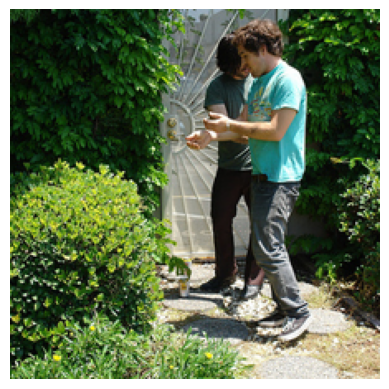

Caption-en: ('Two young guys with shaggy hair look at their hands while hanging out in the yard.',)
Caption-pt: ('Dois jovens com cabelo fraco olham para as mãos enquanto ficam no quintal.',)
____________________________________________________________________________________________________


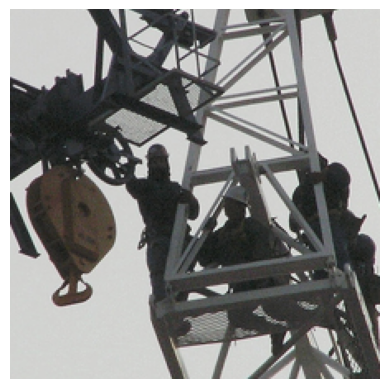

Caption-en: ('Several men in hard hats are operating a giant pulley system.',)
Caption-pt: ('Vários homens em chapéus duros estão operando um sistema de poleia gigante.',)
____________________________________________________________________________________________________


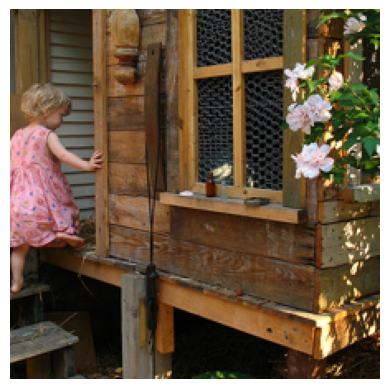

Caption-en: ('A child in a pink dress is climbing up a set of stairs in an entry way.',)
Caption-pt: ('Uma criança em um vestido rosa está subindo um conjunto de escadas de uma maneira de entrada.',)
____________________________________________________________________________________________________


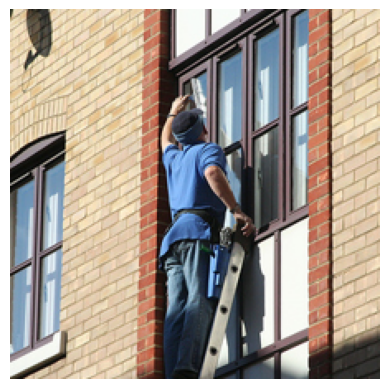

Caption-en: ('Someone in a blue shirt and hat is standing on stair and leaning against a window.',)
Caption-pt: ('Alguém com uma camisa azul e chapéu está de pé sobre a escada e se apoiando contra uma janela.',)
____________________________________________________________________________________________________


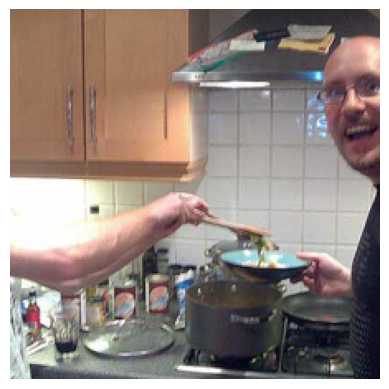

Caption-en: ('Two men, one in a gray shirt, one in a black shirt, standing near a stove.',)
Caption-pt: ('Dois homens, um em uma camisa cinza, um em uma camisa preta, em pé perto de um fogão.',)
____________________________________________________________________________________________________


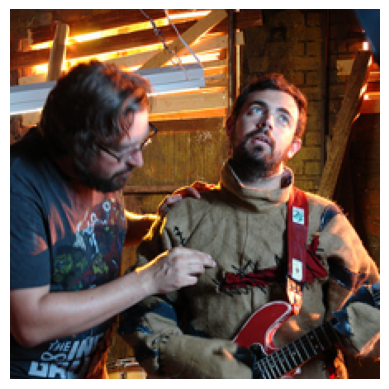

Caption-en: ('Two people in the photo are playing the guitar and the other is poking at him.',)
Caption-pt: ('Duas pessoas na foto estão tocando a guitarra e a outra está cutucando-o.',)
____________________________________________________________________________________________________


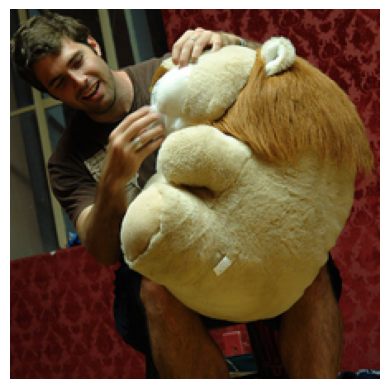

Caption-en: ('A man sits in a chair while holding a large stuffed animal of a lion.',)
Caption-pt: ('Um homem senta-se em uma cadeira enquanto segurando um grande animal de peluche de um leão.',)
____________________________________________________________________________________________________


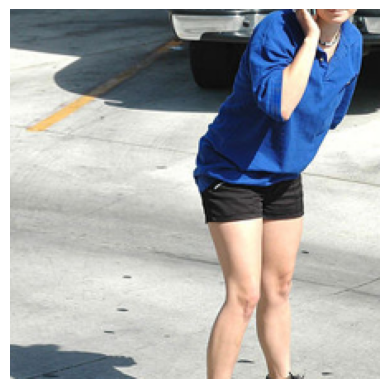

Caption-en: ('A girl is on rollerskates talking on her cellphone standing in a parking lot.',)
Caption-pt: ('Uma rapariga está em patins a falar no telemóvel de pé num estacionamento.',)
____________________________________________________________________________________________________


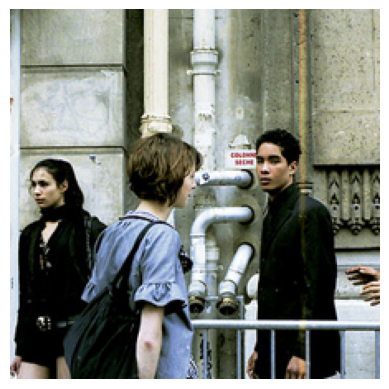

Caption-en: ('An asian man wearing a black suit stands near a dark-haired woman and a brown-haired woman.',)
Caption-pt: ('Um homem asiático vestindo um terno preto fica perto de uma mulher de cabelo escuro e uma mulher de cabelo castanho.',)
____________________________________________________________________________________________________


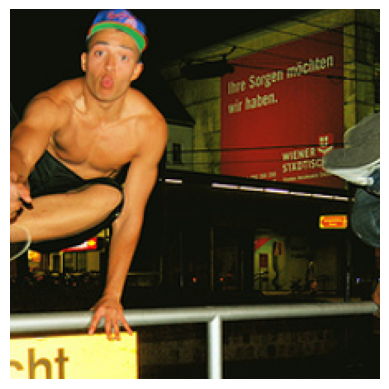

Caption-en: ('Two men in Germany jumping over a rail at the same time without shirts.',)
Caption-pt: ('Dois homens na Alemanha pulando sobre um trem ao mesmo tempo sem camisas.',)
____________________________________________________________________________________________________


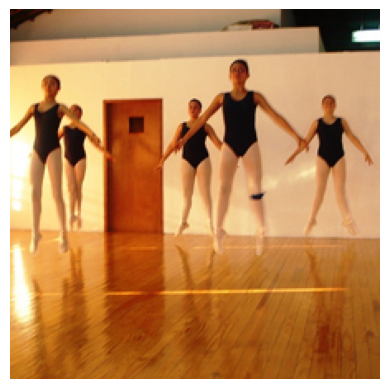

Caption-en: ('Five ballet dancers caught mid jump in a dancing studio with sunlight coming through a window.',)
Caption-pt: ('Cinco dançarinos de balé apanhados no meio salto em um estúdio de dança com a luz do sol chegando através de uma janela.',)
____________________________________________________________________________________________________


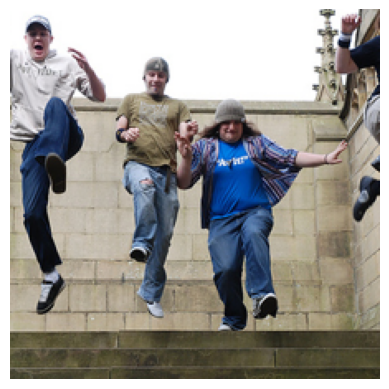

Caption-en: ('Three young men and a young woman wearing sneakers are leaping in midair at the top of a flight of concrete stairs.',)
Caption-pt: ('Três homens jovens e uma jovem mulher usando tênis estão pulando no meio do ar no topo de um vôo de escadas de concreto.',)
____________________________________________________________________________________________________


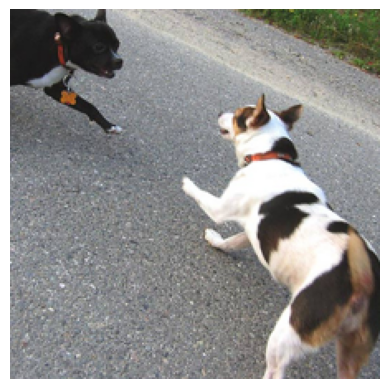

Caption-en: ('A black dog and a white dog with brown spots are staring at each other in the street.',)
Caption-pt: ('Um cão preto e um cão branco com manchas marrom estão olhando um para o outro na rua.',)
____________________________________________________________________________________________________


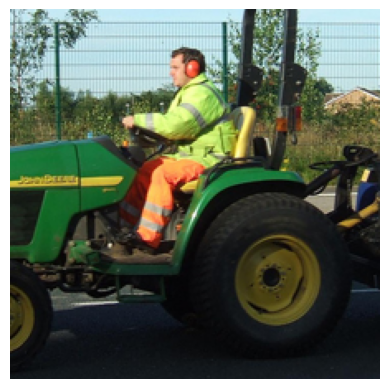

Caption-en: ('A man with reflective safety clothes and ear protection drives a John Deere tractor on a road.',)
Caption-pt: ('Um homem com roupas de segurança reflexivas e proteção do ouvido conduz um trator John Deere em uma estrada.',)
____________________________________________________________________________________________________


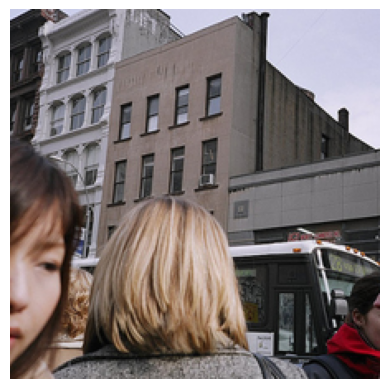

Caption-en: ('Some women are standing in front of a bus with buildings behind it.',)
Caption-pt: ('Algumas mulheres estão em pé na frente de um ônibus com edifícios atrás dele.',)
____________________________________________________________________________________________________


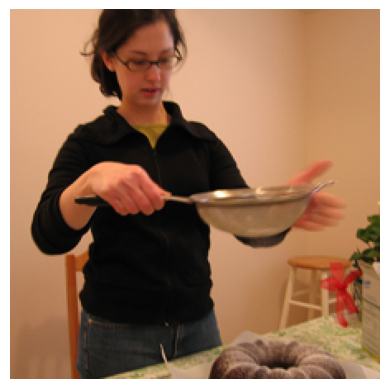

Caption-en: ('A young woman with dark hair and wearing glasses is putting white powder on a cake using a sifter.',)
Caption-pt: ('Uma jovem mulher com cabelo escuro e usando óculos está colocando pó branco em um bolo usando um varredor.',)
____________________________________________________________________________________________________


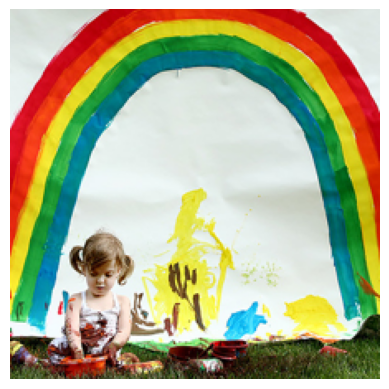

Caption-en: ('A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it.',)
Caption-pt: ('Uma menina pequena na grama brinca com pinturas dedos na frente de uma tela branca com um arco-íris nele.',)
____________________________________________________________________________________________________


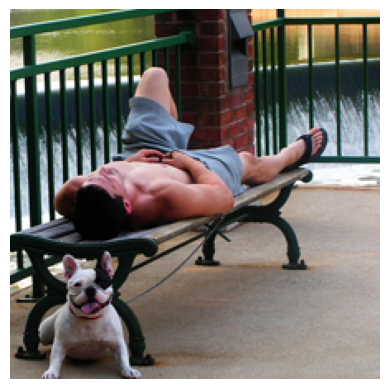

Caption-en: ('A man sleeping on a bench outside with a white and black dog sitting next to him.',)
Caption-pt: ('um homem dormindo em um banco fora com um cão branco e preto sentado ao lado dele.',)
____________________________________________________________________________________________________


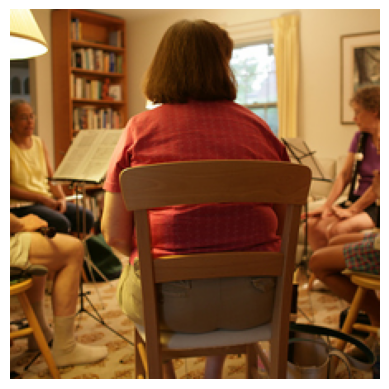

Caption-en: ('A group of adults, inside a home, sitting on chairs arranged in a circle, playing a type of musical instruments.',)
Caption-pt: ('Um grupo de adultos, dentro de uma casa, sentado em cadeiras dispostas em um círculo, tocando um tipo de instrumentos musicais.',)
____________________________________________________________________________________________________


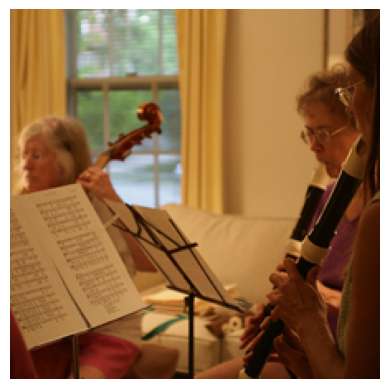

Caption-en: ('Two women, both wearing glasses, are playing clarinets and an elderly woman is playing a stringed instrument.',)
Caption-pt: ('Duas mulheres, ambas usando óculos, estão tocando clarinetes e uma mulher idosa está tocando um instrumento de cordas.',)
____________________________________________________________________________________________________


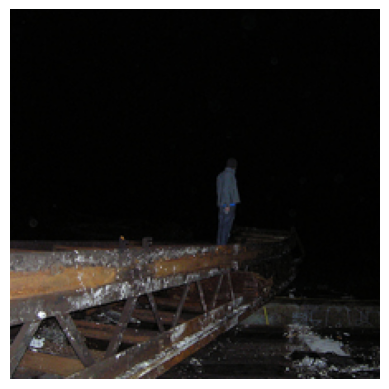

Caption-en: ('A person in gray stands alone on a structure outdoors in the dark.',)
Caption-pt: ('Uma pessoa em cinza fica sozinho em uma estrutura ao ar livre no escuro.',)
____________________________________________________________________________________________________


In [3]:
import os
import json
import torch 
import webdataset as wds
import matplotlib.pyplot as plt
from transformers import CLIPProcessor
from transformers import AutoTokenizer 

home_directory = os.path.expanduser( '~' )
dataset_path = os.path.join(home_directory, "dataset_flickr30k.json")
image_base_dir = os.path.join(home_directory, "flickr30k/flickr30k_images")
translation_path = os.path.join(home_directory, "dataset_clip_pt/flickr30k/results_20130124_ptbr.token")

dataset = CustomDataset(dataset_name='flickr30k', dataset_path=dataset_path,
                       image_base_dir=image_base_dir, translation_path=translation_path)

vision_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
text_tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
    
batch_size=1
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,                                          
                                         num_workers=4)

count = 20
for data in dataloader:    
    images, metadata = data        
    plt.imshow(images[0].permute(1,2,0).numpy()) # get the image in the batch
    plt.axis(False)
    plt.show()
    print('Caption-en:', metadata['captions-en'][0]) # get the captions in the batch
    print('Caption-pt:', metadata['captions-pt'][0])
    print('_'*100)
    if count == 0:
        break
    count -= 1    